In [41]:
import pandas as pd
import pickle as pkl
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from ast import literal_eval

## Ensemble model

In [34]:
with open ("/work/magroup/kaileyhu/res/neg_sampling/metrics/EXP_5_CV1/ESM2_film_general_ensemble_x15.pkl", "rb") as f:
    uq = pkl.load(f)

In [35]:
corr = uq['corr']
pred_vals = uq['pred_vals']

In [36]:
pred_vals = np.array(pred_vals)

In [37]:
column_variances = np.var(pred_vals, axis=0)

In [38]:
np.average(column_variances)

0.049795104948136465

In [39]:
num_models = 15

certain_wrong = {}
correct_dict = {}
wrong_dict = {}
certain_correct = {}
for i in tqdm(range(len(column_variances))):
    u = column_variances[i]
    u = float(f'{u:.10f}')
    if u not in correct_dict:
        correct_dict[u] = 0
        wrong_dict[u] = 0
        certain_wrong[u] = []
        certain_correct[u] = []

    for j in range(5):
        if pred_vals[j][i] == corr[i]:
            correct_dict[u] += 1
            if j == 0:
                certain_correct[u].append(list(test_names.iloc[i]))
        else:
            wrong_dict[u] += 1
            if j == 0:
                certain_wrong[u].append(list(test_names.iloc[i]))

  0%|          | 0/1197041 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'iloc'

In [ ]:
correct_dict, wrong_dict

In [ ]:
# Ensure the keys are sorted for a consistent plot order
sorted_keys = sorted(list(correct_dict.keys()))

# Extract the values in the sorted order
correct_values = [correct_dict.get(key, 0) for key in sorted_keys]
incorrect_values = [wrong_dict.get(key, 0) for key in sorted_keys]

# Prepare the data for plotting
labels = [f'{key:.10f}' for key in sorted_keys]
x = np.arange(len(labels))

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Create the stacked bar chart
bar1 = ax.bar(x, correct_values, label='Correct Predictions', color='forestgreen')
bar2 = ax.bar(x, incorrect_values, bottom=correct_values, label='Incorrect Predictions', color='indianred')

# Add labels, title, and legend
ax.set_ylabel('Number of samples')
ax.set_xlabel('Uncertainty score generated by ensemble variance')
ax.set_title('Volume of correct vs. incorrect predictions by uncertainty score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of the bars
for i in range(len(correct_values)):
    total_value = correct_values[i] + incorrect_values[i]
    ax.text(x[i], total_value, str(total_value), ha='center', va='bottom')

fig.tight_layout()
plt.savefig('stacked_correct_vs_incorrect_bar_chart.png')
print("Stacked bar chart saved to stacked_correct_vs_incorrect_bar_chart.png")

In [ ]:
SL_df = pd.read_csv("/work/magroup/kaileyhu/datasets/SynLethDB/Human_SL.csv")

In [40]:
super_certain_wrong = certain_wrong[0.00]

In [ ]:
sources = []
for genes in tqdm(super_certain_wrong):
    gene1, gene2 = genes
    SL_df2 = SL_df[SL_df['n1.name'] == gene1]
    SL_df2 = SL_df2[SL_df2['n2.name'] == gene2]
    SL_df3 = SL_df[SL_df['n2.name'] == gene1]
    SL_df3 = SL_df3[SL_df3['n1.name'] == gene2]
    SL_df_new = pd.concat([SL_df2, SL_df3])
    if len(SL_df_new) > 0:
        sources.append(SL_df_new['r.source'].iloc[0])
    else:
        sources.append('Negative sampling')

# Conformal prediction

In [42]:
import sys
sys.path.append('/work/magroup/kaileyhu/synthetic_lethality')

In [43]:
with open ("/work/magroup/kaileyhu/res/ablations/cv1/gene2vec_UQ_TISSUE_5_fold.pkl", "rb") as f: #_tester
    uq = pkl.load(f)

In [44]:
uq.keys()

dict_keys(['uncertainty_quantification', 'mondrian_pred_vals', 'mondrian_corr', 'mondrian_conf_scores', 'mondrian_test_names', 'mondrian_alpha_to_quantile'])

In [45]:
test_names = uq['mondrian_test_names']

In [46]:
# extract patients
patient_names = [list(map(lambda x : x.split(',')[0][1:], list(test_names[i].index))) for i in range(len(test_names))]

In [47]:
test_names = [test_names[i][['gene 1', 'gene 2']] for i in range(len(test_names))]

In [48]:
corr = uq['mondrian_corr']
pred_vals = uq['mondrian_pred_vals']
conf_scores = uq['mondrian_conf_scores']

In [49]:
certain_wrong = {}
certain_right = {}

In [50]:
# corr = [corr]
# pred_vals = [pred_vals]
# conf_scores = [conf_scores]

In [51]:
fold_list = [[fold for i in range(len(corr[fold]))] for fold in range(len(corr))]

In [52]:
# fake dict funcs
# test_genes_1 = [test_names[fold]['gene 1'] for fold in range(len(corr))]
# test_genes_2 = [test_names[fold]['gene 2'] for fold in range(len(corr))]

In [53]:
test_genes_1 = [list(test_names[fold]['gene 1']) for fold in range(len(corr))]
test_genes_2 = [list(test_names[fold]['gene 2']) for fold in range(len(corr))]

In [54]:
test_genes_1 = [item for sublist in test_genes_1 for item in sublist]
test_genes_2 = [item for sublist in test_genes_2 for item in sublist]

In [55]:
corr = [item for sublist in corr for item in sublist]

In [56]:
pred_vals = [item for sublist in pred_vals for item in sublist]
conf_scores = [item for sublist in conf_scores for item in sublist]
fold_list = [item for sublist in fold_list for item in sublist]
patient_names = [item for sublist in patient_names for item in sublist]

In [57]:
uq_df = pd.DataFrame({'gene 1': test_genes_1, 'gene 2' : test_genes_2, 'label' : corr, 'pred' : pred_vals, 'conf' : conf_scores, 'fold' : fold_list, 'patient' : patient_names})

In [58]:
uq_df

,gene 1,gene 2,label,pred,conf,fold,patient
0,CIDEA,NAE1,0,1,0.001,0,ACH-000486
1,CIDEA,NAE1,0,1,0.001,0,ACH-001370
2,CIDEA,NAE1,0,1,0.001,0,ACH-000434
3,KRAS,HIPK1,0,0,0.006,0,ACH-000754
4,KRAS,HIPK1,0,0,0.002,0,ACH-001415
...,...,...,...,...,...,...,...
2750055,MFNG,PLOD1,0,0,0.013,4,ACH-001688
2750056,MFNG,PLOD1,0,1,0.015,4,ACH-000697
2750057,MFNG,PLOD1,0,0,0.004,4,ACH-001656
2750058,MFNG,PLOD1,0,1,0.016,4,ACH-000124


In [59]:
uq_df['conf'] = uq_df['conf'].apply(lambda x : round(x, 2))

In [60]:
uq_df['correct'] = uq_df.apply(lambda row : row['label'] == row['pred'], axis = 1)

In [61]:
SL_df = pd.read_csv("/work/magroup/kaileyhu/datasets/SynLethDB/Human_SL.csv")

In [62]:
nonSL_df = pd.read_csv("/work/magroup/kaileyhu/datasets/SynLethDB/Human_nonSL.csv")

In [63]:
SL_df['gene_pairs'] = SL_df.apply(lambda row : (row['n1.name'], row['n2.name']), axis = 1)
nonSL_df['gene_pairs'] = nonSL_df.apply(lambda row : (row['n1.name'], row['n2.name']), axis = 1)

In [64]:
uq_df['gene_pairs'] = uq_df.apply(lambda row : (row['gene 1'], row['gene 2']), axis = 1)

In [65]:
pair_to_source = SL_df.set_index('gene_pairs')['r.source'].to_dict()
pair_to_source = pair_to_source | nonSL_df.set_index('gene_pairs')['r.source'].to_dict()

In [66]:
def query_dict(x):
    if x in pair_to_source:
        return pair_to_source[x]
    x_rev = (x[1], x[0])
    if x_rev in pair_to_source:
        return pair_to_source[x_rev]
    else:
        return 'Negative sampling'

In [67]:
uq_df['source'] = uq_df['gene_pairs'].apply(query_dict)

In [68]:
uq_df['conf'] = uq_df['conf'].apply(lambda u : float(f'{u:.10f}'))

In [69]:
with open ("/work/magroup/kaileyhu/datasets/SynLethSampled/all_pairs_NSP_EXP_5x.pkl", "rb") as f:
    pair_list = pkl.load(f)

print(f"Length of all pairs is {len(pair_list)}, length of SynLethDB samples is {len(SL_df)}")

Length of all pairs is 198219, length of SynLethDB samples is 35943


In [70]:
non_SL = uq_df[uq_df['label'] == 0]
SL = uq_df[uq_df['label'] == 1]

non_neg = non_SL[non_SL['source'] != 'Negative sampling']

In [71]:
# distribution of uncertainty for negative sampling

all_conf_scores = np.unique(list(uq_df['conf']))

neg_sampling_count = {}
SL_count = {}
nonSL_count = {}
total_counts = {}

for u in all_conf_scores:
    conf_df = uq_df[uq_df['conf'] == u]
    u = float(f'{u:.10f}')
    ns = conf_df[conf_df['source'] == 'Negative sampling']
    neg_sampling_count[u] = len(ns)
    SL_count[u] = len(ns[ns['label'] == 1])
    nonSL_count[u] = len(ns[ns['label'] == 0])
    total_counts[u] = (len(conf_df), len(SL[SL['conf'] == u]), len(non_SL[non_SL['conf'] == u]))

In [72]:
for key in neg_sampling_count:
    neg_sampling_count[key] /= total_counts[key][0]

for key in SL_count:
    if total_counts[key][1] != 0:
        SL_count[key] /= total_counts[key][1]

for key in nonSL_count:
    if total_counts[key][2] != 0:
        nonSL_count[key] /= total_counts[key][2]

In [73]:
all_conf_scores

array([0.  , 0.01, 0.02, 0.03])

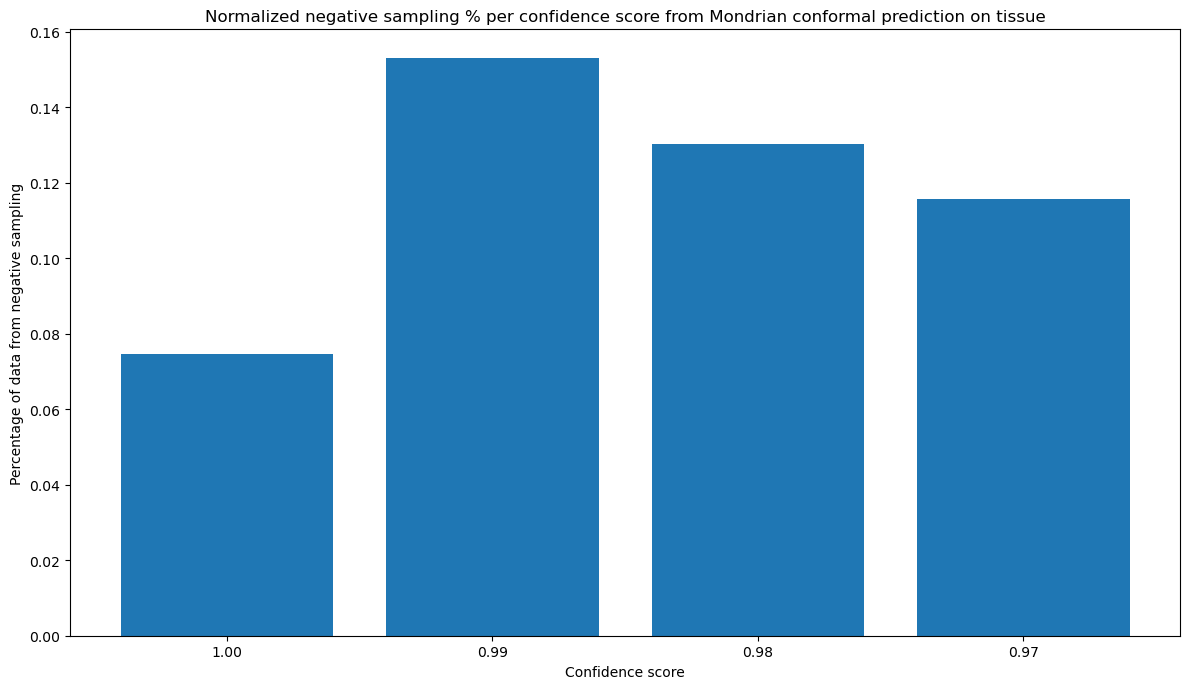

In [77]:
neg_sampling = neg_sampling_count

items = list(set(list(neg_sampling.keys()) + list(SL_count.keys()) + list(nonSL_count.keys())))

all_labels = sorted(list(set(items)))
index = np.arange(len(items))

overall_values = [neg_sampling.get(label, 0) for label in all_labels]
SL_values = [SL_count.get(label, 0) for label in all_labels]
nonSL_values = [nonSL_count.get(label, 0) for label in all_labels]


all_labels = [f"{(1 - x):.2f}" for x in all_labels]
plt.figure(figsize=(12, 7))
# Plot the bars side by side
bar_width = 0.25 # Adjust the width of each bar
plt.bar(index, overall_values, label='overall percentage')
# plt.bar(index, SL_values, bar_width, label='SL percentage', color='green')
# plt.bar(index + bar_width, nonSL_values, bar_width, label='nonSL percentage', color='red')

# # Customize the plot
# plt.ylabel('normalized counts')
# plt.title('Normalized counts of SL pair source based on model certainty')
# plt.xticks(index, all_labels, rotation=90, fontsize=10)
# plt.legend()
plt.tight_layout()
# plt.show()

plt.xticks(index, all_labels, fontsize=10)
plt.xlabel("Confidence score")

plt.ylabel("Percentage of data from negative sampling")
plt.title("Normalized negative sampling % per confidence score from Mondrian conformal prediction on tissue")

plt.tight_layout()
plt.show()

In [35]:
uq_correct = uq_df[uq_df['correct']]
uq_wrong = uq_df[~uq_df['correct']]

all_labels = sorted(list(set(uq_df['source'])))

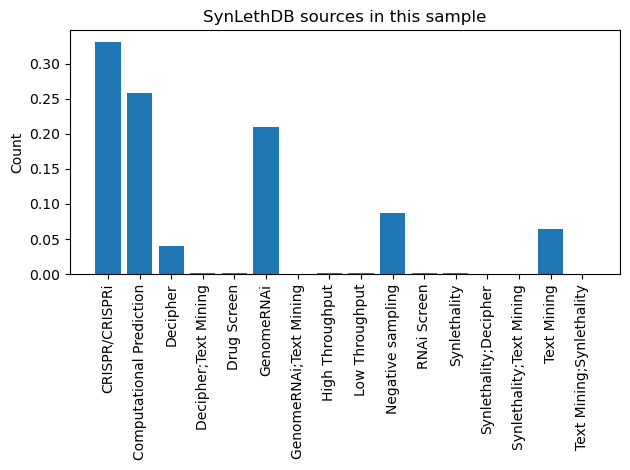

In [36]:
def normalize_counter(my_counter):
    total_sum = sum(my_counter.values())
    normalized_counter = {item: count / total_sum for item, count in my_counter.items()}
    return normalized_counter

synlethdb_sources = Counter(uq_df['source'])
synlethdb_sources = normalize_counter(synlethdb_sources)

items = list(synlethdb_sources.keys())
counts = list(synlethdb_sources.values())

index = np.arange(len(items))

SL_df_values = [synlethdb_sources.get(label, 0) for label in all_labels]

plt.bar(items, SL_df_values)

plt.xticks(index, all_labels, rotation=90, fontsize=10)

plt.ylabel("Count")
plt.title("SynLethDB sources in this sample")

plt.tight_layout()
plt.show()

In [37]:
def normalize_data(data):
    my_counter = Counter(data)
    total_sum = sum(my_counter.values())
    normalized_counter = {item: count / total_sum for item, count in my_counter.items()}
    return normalized_counter

def generate_bar(u):
    corr_preds = uq_correct[uq_correct['conf'] == u]
    wrong_preds = uq_wrong[uq_wrong['conf'] == u]

    sources = normalize_data(list(corr_preds['source'])+list(wrong_preds['source']))
    values = [sources.get(label, 0) for label in all_labels]
    return values

def generate_corr(u):
    corr_preds = uq_correct[uq_correct['conf'] == u]

    sources = normalize_data(list(corr_preds['source']))
    values = [sources.get(label, 0) for label in all_labels]
    return values

def generate_wrong(u):
    wrong_preds = uq_wrong[uq_wrong['conf'] == u]

    sources = normalize_data(list(wrong_preds['source']))
    values = [sources.get(label, 0) for label in all_labels]
    return values

In [38]:
all_conf_scores

array([0.  , 0.01, 0.02, 0.03])

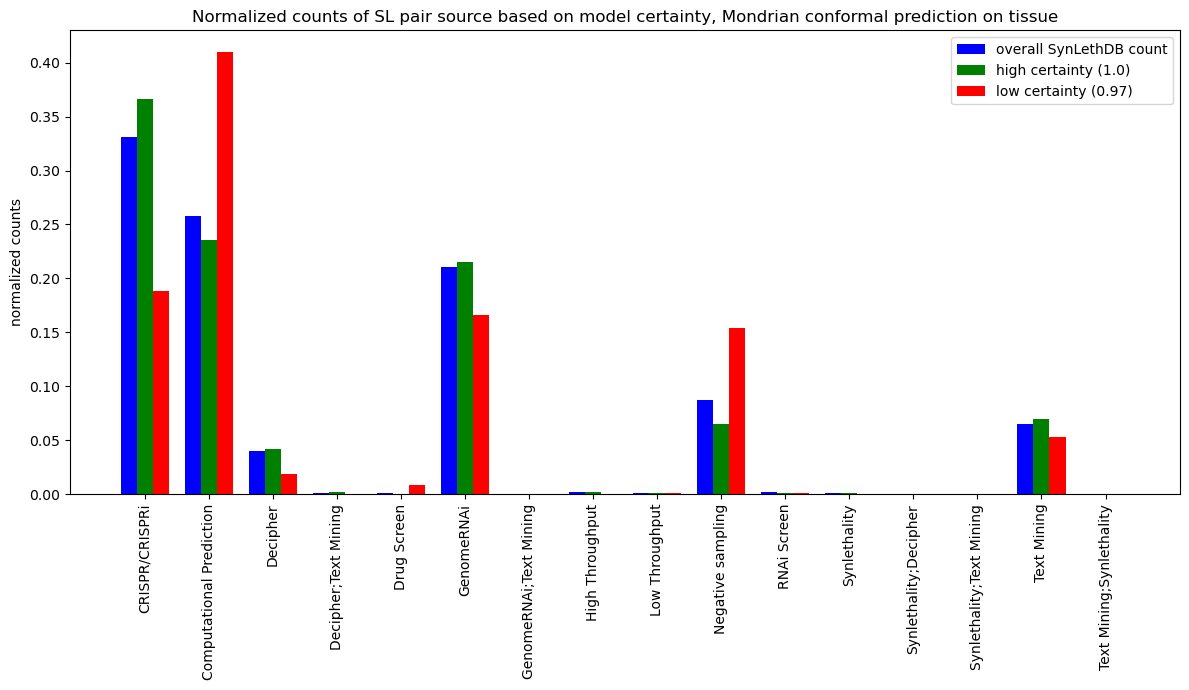

In [39]:
overall_values = SL_df_values
high_certainty_values = generate_bar(0.0) 
low_certainty_values = generate_bar(0.03) 

# Set up the plot parameters
n_groups = len(all_labels)
bar_width = 0.25 # Adjust the width of each bar
index = np.arange(n_groups)

# Create the plot
plt.figure(figsize=(12, 7))

# Plot the bars side by side
plt.bar(index - bar_width, overall_values, bar_width, label='overall SynLethDB count', color='blue')
plt.bar(index, high_certainty_values, bar_width, label='high certainty (1.0)', color='green')
plt.bar(index + bar_width, low_certainty_values, bar_width, label='low certainty (0.97)', color='red')

# Customize the plot
plt.ylabel('normalized counts')
plt.title('Normalized counts of SL pair source based on model certainty, Mondrian conformal prediction on tissue')
plt.xticks(index, all_labels, rotation=90, fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()


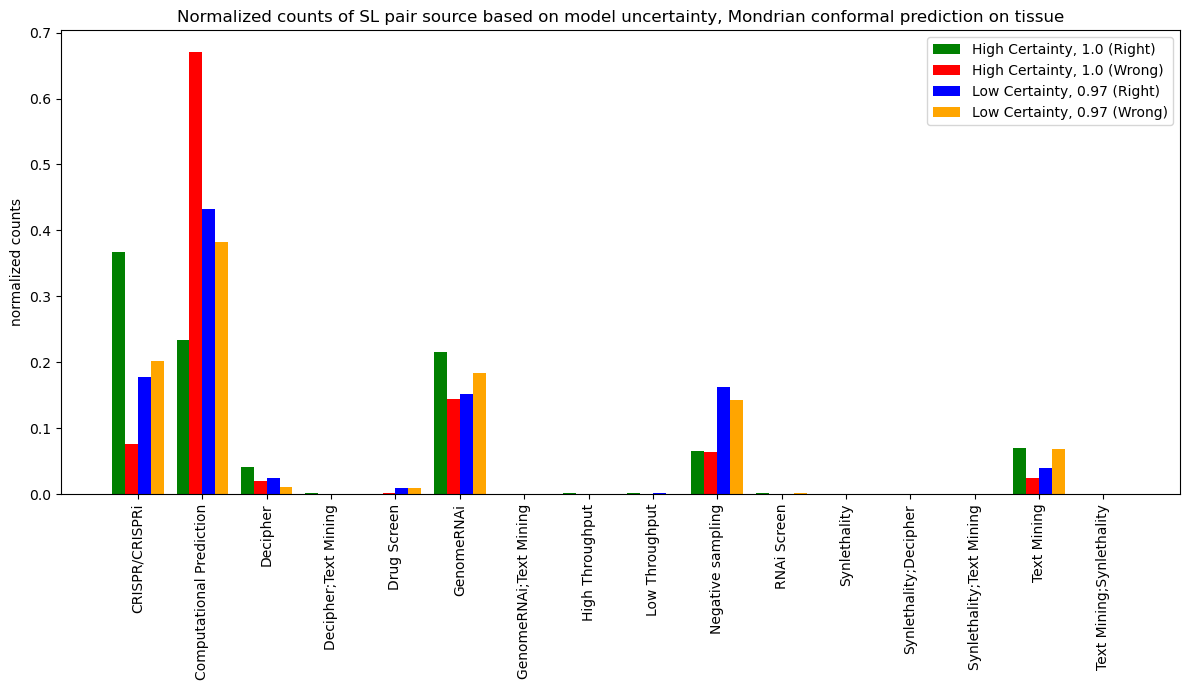

In [40]:
high_certainty_right_values = generate_corr(0.0)
high_certainty_wrong_values = generate_wrong(0.0)
low_certainty_right_values = generate_corr(0.03)
low_certainty_wrong_values = generate_wrong(0.03)

# Set up the plot parameters
n_groups = len(all_labels)
bar_width = 0.2 # Adjust the width of each bar
index = np.arange(n_groups)

# Create the plot
plt.figure(figsize=(12, 7))

# Plot the four sets of bars side by side with offsets
plt.bar(index - 1.5 * bar_width, high_certainty_right_values, bar_width, label='High Certainty, 1.0 (Right)', color='green')
plt.bar(index - 0.5 * bar_width, high_certainty_wrong_values, bar_width, label='High Certainty, 1.0 (Wrong)', color='red')
plt.bar(index + 0.5 * bar_width, low_certainty_right_values, bar_width, label='Low Certainty, 0.97 (Right)', color='blue')
plt.bar(index + 1.5 * bar_width, low_certainty_wrong_values, bar_width, label='Low Certainty, 0.97 (Wrong)', color='orange')

# Customize the plot
plt.ylabel('normalized counts')
plt.title('Normalized counts of SL pair source based on model uncertainty, Mondrian conformal prediction on tissue')
plt.xticks(index, all_labels, rotation=90, fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()

In [91]:
# Look at tissues
with open("/work/magroup/kaileyhu/res/UQ/Mondrian_by_tissue_NSM_EXP_5x.pkl", "rb") as f:
    mondrian_class_dict = pkl.load(f)

def extract_name(x):
    return x["patient"]

In [92]:
uq_df['tissue'] = uq_df['patient'].apply(lambda x : mondrian_class_dict[x])

In [93]:
best_alpha = {}
for t in tqdm(np.unique(list(uq_df['tissue']))):
    temp = uq_df[uq_df['tissue'] == t]
    sorted_list = temp.sort_values(by='conf')['gene_pairs'].tolist()
    unique_list = list(dict.fromkeys(sorted_list))
    best_alpha[t] = unique_list[:10]

100%|██████████| 42/42 [00:12<00:00,  3.41it/s]


In [94]:
def accuracy_by_conf(df, u):
    uq_correct = df[df['correct']]
    uq_wrong = df[~df['correct']]
    corr_preds = uq_correct[uq_correct['conf'] == u]
    wrong_preds = uq_wrong[uq_wrong['conf'] == u]
    if (len(corr_preds) + len(wrong_preds)) == 0:
        return 0
    return len(corr_preds) / (len(corr_preds) + len(wrong_preds))

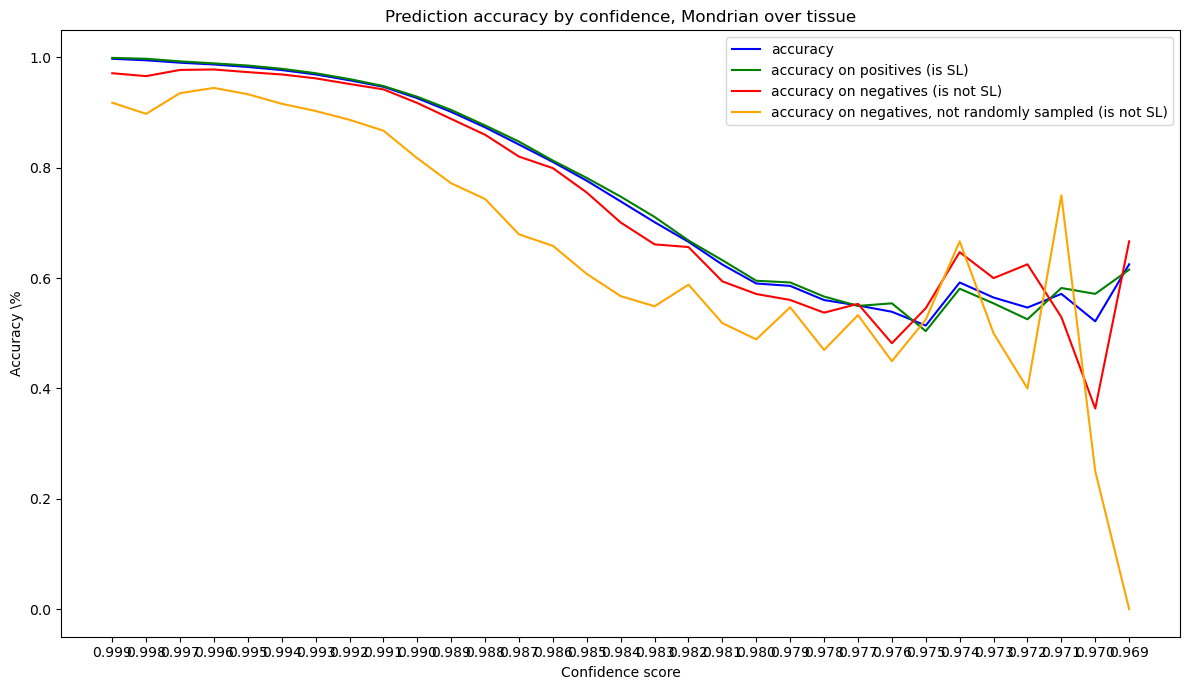

In [96]:
accuracy = []
for u in all_conf_scores:
    accuracy.append(accuracy_by_conf(uq_df, u))

SL_accuracy = []
for u in all_conf_scores:
    SL_accuracy.append(accuracy_by_conf(SL, u))

nonSL_accuracy = []
for u in all_conf_scores:
    nonSL_accuracy.append(accuracy_by_conf(non_SL, u))

nonneg_accuracy = []
for u in all_conf_scores:
    nonneg_accuracy.append(accuracy_by_conf(non_neg, u))

# Set up the plot parameters
n_groups = len(accuracy)
index = np.arange(n_groups)

# Create the plot
plt.figure(figsize=(12, 7))

all_conf_scores2 = [f"{(1-x):.3f}" for x in all_conf_scores]

plt.plot(all_conf_scores2[1:], accuracy[1:], label='accuracy', color='blue')
plt.plot(all_conf_scores2[1:], SL_accuracy[1:], label='accuracy on positives (is SL)', color='green')
plt.plot(all_conf_scores2[1:], nonSL_accuracy[1:], label='accuracy on negatives (is not SL)', color='red')
plt.plot(all_conf_scores2[1:], nonneg_accuracy[1:], label='accuracy on negatives, not randomly sampled (is not SL)', color='orange')

plt.ylabel('Accuracy \%')
plt.title('Prediction accuracy by confidence, Mondrian over tissue')
plt.xlabel('Confidence score')
plt.tight_layout()
plt.legend()
plt.show()

# delete the negative sampling

In [133]:
import matplotlib.cm as cm

# Generate 50 evenly spaced values between 0 and 1
# These values will be used to sample colors from the colormap
color_indices = np.linspace(0, 1, 15)

# Get the 'viridis' colormap
colormap = cm.get_cmap('viridis')

# Apply the colormap to the color_indices to get a list of RGBA tuples
# Each tuple represents a color in (red, green, blue, alpha) format
matplotlib_colors = [colormap(i) for i in color_indices]

/tmp/ipykernel_4104254/892847423.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


In [134]:
num_tissues = {}
for i, t in tqdm(enumerate(np.unique(list(uq_df['tissue'])))):
    num_tissues[t] = len(uq_df[uq_df['tissue'] == t])

42it [00:04,  8.73it/s]


In [135]:
sorted_items_desc = sorted(num_tissues.items(), key=lambda item: item[1], reverse=True)

15it [00:03,  5.00it/s]


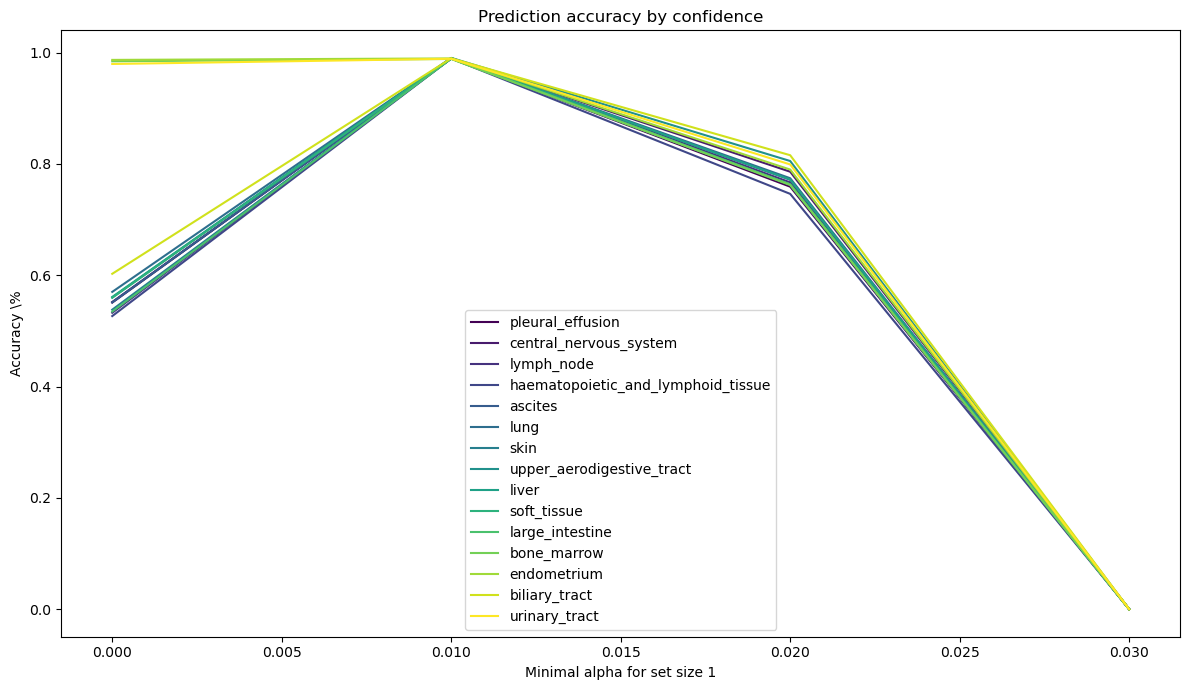

In [136]:
plt.figure(figsize=(12, 7))

for i, t in tqdm(enumerate(list(dict(sorted_items_desc).keys())[:15])):
    accuracy = []
    temp = uq_df[uq_df['tissue'] == t]

    for u in all_conf_scores:
        accuracy.append(accuracy_by_conf(temp, u))

    plt.plot(all_conf_scores, accuracy, label=t, color=matplotlib_colors[i])



plt.ylabel('Accuracy \%')
plt.title('Prediction accuracy by confidence')
plt.xlabel('Minimal alpha for set size 1')
plt.tight_layout()
plt.legend()
plt.show()


In [325]:
SL_df[SL_df['gene_pairs'] == ('MRPS5', 'NFE2L1')]

,n1.name,n1.identifier,n2.name,n2.identifier,r.cell_line,r.pubmed_id,r.source,r.statistic_score,gene_pairs
23768,MRPS5,64969,NFE2L1,4779,K562,31300006,CRISPR/CRISPRi,0.85,"(MRPS5, NFE2L1)"


In [45]:
best_alpha['lung']

[('AGPAT1', 'ILK'),
 ('NUP85', 'ZWINT'),
 ('NUP85', 'PNN'),
 ('MAPK12', 'RAD23B'),
 ('MARVELD3', 'P3H1'),
 ('ANKLE1', 'FKBP9'),
 ('MAPK12', 'RELA'),
 ('SPAG5', 'NASP'),
 ('MRPS5', 'NFE2L1'),
 ('MRPS5', 'VPS29')]

## Make mondrian groups for UQ

In [127]:
# create mondrian sets by SL label
mondrian_groups = {k: int(v) for (k, v) in pair_list.items()}

In [129]:
with open ("/work/magroup/kaileyhu/res/UQ/Mondrian_by_SL_NSM_EXP_5x.pkl", "wb") as f:
    pkl.dump(mondrian_groups, f)

In [8]:
SL_df['gene_pairs'][0]

('TMEM35A', 'PTEN')

In [9]:
# sets by tissue label
metadata = pd.read_csv("/work/magroup/kaileyhu/datasets/depmap/metadata.csv")
metadata.set_index("ModelID", inplace = True)

In [10]:
tissues_query = dict(metadata["SampleCollectionSite"])

In [13]:
with open ("/work/magroup/kaileyhu/datasets/depmap/patient_to_tissue_dict.pkl", "wb") as f:
    pkl.dump(tissues_query, f)

In [20]:
with open ("/work/magroup/kaileyhu/res/UQ/Mondrian_by_tissue_NSM_EXP_5x.pkl", "wb") as f:
    pkl.dump(tissues_query, f)

In [18]:
# set by sampling source
mondrian_groups = {SL_df.iloc[i]['gene_pairs']: SL_df.iloc[i]['r.source'] for i in range(len(SL_df))}

In [21]:
with open ("/work/magroup/kaileyhu/res/UQ/Mondrian_by_source_NSM_EXP_5x.pkl", "wb") as f:
    pkl.dump(mondrian_groups, f)